In [1]:
!pip install fasttext
!pip install deep-translator
!pip install datasets
!pip install accelerate -U
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 684.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227137 sha256=96edbdc556c37ef1645e0b26142fc7f1f98f0ffcb81a19c5ef7508d65ff2d469
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
from copy import deepcopy
from collections import defaultdict, Counter
import random
import time
import re
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # lexicon-based

import spacy

from bs4 import BeautifulSoup

import fasttext
from deep_translator import GoogleTranslator  # https://github.com/nidhaloff/deep-translator

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, confusion_matrix,
                             accuracy_score, f1_score, precision_score, recall_score)


import transformers
from transformers import pipeline
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset, DatasetDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.transforms import ToTensor
import torchtext.vocab as vocab

from keras_preprocessing.sequence import pad_sequences

## **Constants**<a id='constants'></a>

In [5]:
SEED = 42

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# transformers.set_seed(SEED)

RAW_DATA_DIR = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(RAW_DATA_DIR, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(RAW_DATA_DIR, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'test_reviews.xlsx')

TRAIN_PREPROCESSED_PATH = os.path.join('corpora', 'train_preprocessed.pkl')
TEST_PREPROCESSED_PATH = os.path.join('corpora', 'test_preprocessed.pkl')

TRAIN_PREPROCESSED_PATH_DRIVE = '/content/drive/MyDrive/text-mining-pre-processed-data/train_preprocessed.pkl'
TEST_PREPROCESSED_PATH_DRIVE = '/content/drive/MyDrive/text-mining-pre-processed-data/test_preprocessed.pkl'

In [6]:
# keep in mind that the pre processed datasets contain all transformations history meaning
# we can source from the same ds the same column before and after any transformation

def load_preprocessed_data(columns=None, *, train_path, test_path):

    train_df = pd.read_pickle(train_path)
    test_df = pd.read_pickle(test_path)

    if columns:

        if isinstance(columns, str):
            columns = [columns]

        # just making sure that the columns are in the dataset
        columns_train = list(set(columns + ['property_index', 'unlisted']))
        columns_test = list(set(columns + ['property_index']))

        train_df = train_df[columns_train]
        test_df = test_df[columns_test]

    return train_df, test_df


def groupby_property(df):

    for col in df.columns:
        if ('index' in col) and (col != 'property_index'):
            df.drop(col, axis=1, inplace=True)

    if 'comment_index' in df.columns:
        df = df.drop('comment_index', axis=1)

    unlisted_exists = False
    if 'unlisted' in df.columns:
        unlisted_exists = True
        label_dict = {property_id: label for property_id, label in zip(df['property_index'], df['unlisted'])}
        df = df.drop('unlisted', axis=1)  # otherwise groupby would return error -> ''.join([ints...]) raises TypeError

    new_df = df.groupby('property_index').agg(lambda x: ' '.join(set(x))).reset_index()

    if unlisted_exists:
        new_df['unlisted'] = new_df['property_index'].map(label_dict)

    return new_df

In [7]:
# due to sheer amount of data k-fold cross-validation will not be feasible
# so a train-val-test split is preferred

def two_step_proportions(train_p, val_p, test_p):
    """
    Since we need to split the data in two steps
    this function returns the proportions of the
    'test_size' arg. needed to get the true prop.
    """
    return (test_p, 1-(train_p/(1-test_p)))


def stratified_train_val_test_split(X, y, proportions=(.8, .1, .1)):

    test_size_1, test_size_2 = two_step_proportions(*proportions)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                                y,
                                                                test_size=test_size_1,
                                                                shuffle=True,
                                                                stratify=y,
                                                                random_state=SEED)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                      y_train_val,
                                                      test_size=test_size_2,
                                                      shuffle=True,
                                                      stratify=y_train_val,
                                                      random_state=SEED)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [ ]:
class ExtractGloVe:
    def __init__(self, name, dim, cache_dir=None):
        self.name = name
        self.dim = dim
        self.cache_dir = cache_dir

        if cache_dir:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim, cache=self.cache_dir)
        else:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim)

    def _get_glove_token_embedding(self, word):
        word_idx = self.glove.stoi.get(word)
        if word_idx is None:
            return torch.zeros(self.dim)
        return self.glove.vectors[word_idx]

    def get_sentence_embeddings(self, corpus):
        glove_embeddings = []
        for text in tqdm(corpus, total=len(corpus), desc=f'Extracting GloVe Embeddings ({self.dim})'):
            tokenized_text = text.split()
            text_embeddings = np.mean(np.array([self._get_glove_token_embedding(token) for token in tokenized_text]), axis=0)
            glove_embeddings.append(text_embeddings)
        return np.array(glove_embeddings)

- **Creating Datasets**

In [ ]:
def create_glove_datasets(column,
                          model_name,
                          dim,
                          group = True,
                          *,
                          cache_dir = None,
                          train_path=TRAIN_PREPROCESSED_PATH_DRIVE,
                          test_path=TEST_PREPROCESSED_PATH_DRIVE,
                          split_proportions=(.8, .1, .1)):

    # 1. load data
    train_df = load_preprocessed_data(columns=column, train_path=train_path, test_path=test_path)[0]

    # if more than one column is passed, concatenate them
    if isinstance(column, list) and len(column) > 1:

        def concat(*texts):
            return ' '.join(texts)

        train_df['concatenated'] = train_df[[col for col in column]].apply(lambda x: concat(*x), axis=1)
        column = 'concatenated'


    # 2. group by property
    if group:
        train_df = groupby_property(train_df)

    # 3. split
    X = np.array(train_df[column])
    y = np.array(train_df['unlisted'])
    X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y, proportions=split_proportions)

    # 4. get embeddings
    if cache_dir:
        glove = ExtractGloVe(model_name, dim, cache_dir)
    else:
        glove = ExtractGloVe(model_name, dim)
    X_train_glove = glove.get_sentence_embeddings(X_train)
    X_val_glove = glove.get_sentence_embeddings(X_val)
    X_test_glove = glove.get_sentence_embeddings(X_test)

    return X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test

In [ ]:
glove_datasets = {}
# glove_cache_dir = '/content/drive/MyDrive/.vector_cache'  # only need to if using colab
glove_cache_dir = '.vector_cache'

# dataset 1:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 50  # allows for 50, 100, 200 and 300

X_train_glove_50d, X_val_glove_50d, X_test_glove_50d, y_train_glove_50d, y_val_glove_50d, y_test_glove_50d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                   cache_dir=glove_cache_dir,
                                                                                                                                   train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                   test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_50d'] = {
    'X_train': X_train_glove_50d,
    'X_val': X_val_glove_50d,
    'X_test': X_test_glove_50d,
    'y_train': y_train_glove_50d,
    'y_val': y_val_glove_50d,
    'y_test': y_test_glove_50d,
}

# dataset 2:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 100

X_train_glove_100d, X_val_glove_100d, X_test_glove_100d, y_train_glove_100d, y_val_glove_100d, y_test_glove_100d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_100d'] = {
    'X_train': X_train_glove_100d,
    'X_val': X_val_glove_100d,
    'X_test': X_test_glove_100d,
    'y_train': y_train_glove_100d,
    'y_val': y_val_glove_100d,
    'y_test': y_test_glove_100d,
}

# dataset 3:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 200

X_train_glove_200d, X_val_glove_200d, X_test_glove_200d, y_train_glove_200d, y_val_glove_200d, y_test_glove_200d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_200d'] = {
    'X_train': X_train_glove_200d,
    'X_val': X_val_glove_200d,
    'X_test': X_test_glove_200d,
    'y_train': y_train_glove_200d,
    'y_val': y_val_glove_200d,
    'y_test': y_test_glove_200d,
}

# dataset 4:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 300

X_train_glove_300d, X_val_glove_300d, X_test_glove_300d, y_train_glove_300d, y_val_glove_300d, y_test_glove_300d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_300d'] = {
    'X_train': X_train_glove_300d,
    'X_val': X_val_glove_300d,
    'X_test': X_test_glove_300d,
    'y_train': y_train_glove_300d,
    'y_val': y_val_glove_300d,
    'y_test': y_test_glove_300d,
}

# dataset 5:
columns = 'lemma_no_stopwords_ner_trans_clean_description'
glove_name = '6B'
glove_dim = 50

X_train_glove_description, X_val_glove_description, X_test_glove_description, y_train_glove_description, y_val_glove_description, y_test_glove_description = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_description'] = {
    'X_train': X_train_glove_description,
    'X_val': X_val_glove_description,
    'X_test': X_test_glove_description,
    'y_train': y_train_glove_description,
    'y_val': y_val_glove_description,
    'y_test': y_test_glove_description,
}

# dataset 6:
columns = ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about', 'lemma_no_stopwords_ner_trans_clean_comments']
glove_name = '6B'
glove_dim = 50

X_train_glove_concat, X_val_glove_concat, X_test_glove_concat, y_train_glove_concat, y_val_glove_concat, y_test_glove_concat = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_concat'] = {
    'X_train': X_train_glove_concat,
    'X_val': X_val_glove_concat,
    'X_test': X_test_glove_concat,
    'y_train': y_train_glove_concat,
    'y_val': y_val_glove_concat,
    'y_test': y_test_glove_concat,
}

Extracting GloVe Embeddings (300): 100%|██████████| 625/625 [00:16<00:00, 38.63it/s]


In [ ]:
# dataset 6:
columns = ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about', 'lemma_no_stopwords_ner_trans_clean_comments']
glove_name = '6B'
glove_dim = 50

X_train_glove_concat, X_val_glove_concat, X_test_glove_concat, y_train_glove_concat, y_val_glove_concat, y_test_glove_concat = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_concat'] = {
    'X_train': X_train_glove_concat,
    'X_val': X_val_glove_concat,
    'X_test': X_test_glove_concat,
    'y_train': y_train_glove_concat,
    'y_val': y_val_glove_concat,
    'y_test': y_test_glove_concat,
}

Extracting GloVe Embeddings (50): 100%|██████████| 625/625 [01:42<00:00,  6.07it/s]


In [ ]:
 # 1. load data
columns = ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about', 'lemma_no_stopwords_ner_trans_clean_comments']
train_df = load_preprocessed_data(columns=columns, train_path=TRAIN_PREPROCESSED_PATH, test_path=TEST_PREPROCESSED_PATH)[0]


def concat(*texts):
    return ' '.join(texts)

train_df['concatenated'] = train_df[[col for col in columns]].apply(lambda x: concat(*x), axis=1)
column = 'concatenated'

train_df = groupby_property(train_df)

## **Classification Models**

In [ ]:
# 1. get pre processed data
# 2. slice / transform data accordingly
# 3. split data
# 4. Aply feature engineering
# 5. fit model
# 6. evaluate model
# 7. make predictions on real test set

In [ ]:
df = pd.read_csv('corpora/corona_NLP.csv', encoding='latin-1')
df  = df[['OriginalTweet', 'Sentiment']].head(10000)
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Extremely Positive', 'Positive', 'Neutral'] else 0)
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20)

stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean(text_list):

    updates = []

    for j in tqdm(text_list):

        text = j

        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )

        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())

        updates.append(text)

    return updates

X_train_clean = clean(X_train)
X_test_clean = clean(X_test)

glove50 = ExtractGloVe('6B', 50, '.vector_cache/')
glove100 = ExtractGloVe('6B', 100, '.vector_cache/')

X_train_clean_embeddings_50 = glove50.get_sentence_embeddings(X_train_clean)
X_train_clean_embeddings_100 = glove100.get_sentence_embeddings(X_train_clean)

X_test_clean_embeddings_50 = glove50.get_sentence_embeddings(X_test_clean)
X_test_clean_embeddings_100 = glove100.get_sentence_embeddings(X_test_clean)

embeddings_dict = {
    '50d': {'X_train': X_train_clean_embeddings_50, 'y_train': y_train,
            'X_val': X_test_clean_embeddings_50, 'y_val': y_test},
    '100d': {'X_train': X_train_clean_embeddings_100, 'y_train': y_train,
            'X_val': X_test_clean_embeddings_100, 'y_val': y_test},
}

knn = KNeighborsClassifier(n_neighbors=5)
knn_preds_dict = train_sklearn_classifier(knn, embeddings_dict)
show_classification_report(knn_preds_dict)


lr = LogisticRegression(max_iter=3000, class_weight='balanced')
lr_preds_dict = train_sklearn_classifier(lr, embeddings_dict)
show_classification_report(lr_preds_dict)

Extracting GloVe Embeddings (100): 100%|██████████| 2000/2000 [00:00<00:00, 2730.34it/s]


Classification report for 50d - Training data
              precision    recall  f1-score   support

           0     0.7521    0.6920    0.7208      3257
           1     0.7995    0.8433    0.8208      4743

    accuracy                         0.7817      8000
   macro avg     0.7758    0.7677    0.7708      8000
weighted avg     0.7802    0.7817    0.7801      8000


Classification report for 50d - Validation data
              precision    recall  f1-score   support

           0     0.5960    0.5612    0.5781       841
           1     0.6945    0.7239    0.7089      1159

    accuracy                         0.6555      2000
   macro avg     0.6452    0.6426    0.6435      2000
weighted avg     0.6531    0.6555    0.6539      2000


------------------------------------------------------

Classification report for 100d - Training data
              precision    recall  f1-score   support

           0     0.7583    0.7013    0.7287      3257
           1     0.8049    0.8465    0

In [ ]:
# TODO get into a dict all embeddings

# e.g. at least the following
# glove sentence embeddings: 50d
# word2vec sentence embeddings: 50d
# xlm-roberta sentence embeddings
# mt5 sentence embeddings

def join_embeddings_dicts(*dicts):
    embeddings_dict = {}
    for dictionary in dicts:
        embeddings_dict.update(dictionary)
    return embeddings_dict


datasets = (
    glove_datasets,
    # xlmr_datasets,
    # mbert_datasets
)

embeddings_dict = join_embeddings_dicts(*datasets)

print(f'Embeddings: {list(embeddings_dict.keys())}\n')

for name, splits in embeddings_dict.items():
    print(f"{name} -> X_train shape: {splits['X_train'].shape} | X_val shape: {splits['X_val'].shape} | X_test shape: {splits['X_test'].shape}")

Embeddings: ['glove_50d', 'glove_100d', 'glove_200d', 'glove_300d', 'glove_description', 'glove_concat']

glove_50d -> X_train shape: (4998, 50) | X_val shape: (625, 50) | X_test shape: (625, 50)
glove_100d -> X_train shape: (4998, 100) | X_val shape: (625, 100) | X_test shape: (625, 100)
glove_200d -> X_train shape: (4998, 200) | X_val shape: (625, 200) | X_test shape: (625, 200)
glove_300d -> X_train shape: (4998, 300) | X_val shape: (625, 300) | X_test shape: (625, 300)
glove_description -> X_train shape: (4998, 50) | X_val shape: (625, 50) | X_test shape: (625, 50)
glove_concat -> X_train shape: (4998, 50) | X_val shape: (625, 50) | X_test shape: (625, 50)


In [ ]:
embeddings_dict['glove_50d'].keys()

dict_keys(['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test'])

In [ ]:
train_ds = load_preprocessed_data(columns=['trans_clean_comments', 'trans_clean_description'], train_path=TRAIN_PREPROCESSED_PATH, test_path=TEST_PREPROCESSED_PATH)[0]
# train_ds = groupby_property(train_ds)

In [ ]:
train_ds

,unlisted,property_index,trans_clean_comments,trans_clean_description
0,0,1,this is a very cozy and comfortable house to s...,this is a shared mixed room in our hostel with...
1,0,1,good,this is a shared mixed room in our hostel with...
2,0,1,my first hostel experience and all i have to s...,this is a shared mixed room in our hostel with...
3,0,1,das hostel war neu und deshalb funktionierte a...,this is a shared mixed room in our hostel with...
4,0,1,it was fine for a dorm but i think for the peo...,this is a shared mixed room in our hostel with...
...,...,...,...,...
363137,0,6248,the location was perfect the apartment was ver...,these apartments are very well located in a go...
363138,0,6248,anas place is exactly as described and even be...,these apartments are very well located in a go...
363139,0,6248,a ana foi muito atenciosa e preocupou se com o...,these apartments are very well located in a go...
363140,0,6248,no wifi nor answer the wifi cant be connected ...,these apartments are very well located in a go...


In [ ]:
train_ds.sort_values('property_index')[train_ds['property_index']==np.random.choice(6248)].head(20)

,property_index,trans_clean_comments,unlisted
828,829,best location and can see rossio square from t...,0


#### **K-Nearest Neighbors**

In [ ]:
def train_sklearn_classifier(clf, embeddings_dict, get_loss_curves=False):
    if get_loss_curves:
        loss_curves = []

    preds_dict = {}
    for embed, splits in embeddings_dict.items():
        # X_train = splits['X_train']
        # X_val = splits['X_val']
        # y_train = splits['y_train']
        # y_val = splits['y_val']

        X_train = splits['X_train'][:100]
        X_val = splits['X_val'][:100]
        y_train = splits['y_train'][:100]
        y_val = splits['y_val'][:100]

        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        val_pred = clf.predict(X_val)

        preds_dict[embed] = {'train_true': y_train, 'val_true': y_val,
                             'train_pred': train_pred, 'val_pred': val_pred}

        if get_loss_curves:
            loss_curves.append((clf.loss_curve_, clf.validation_scores_))

    if get_loss_curves:
        return preds_dict, loss_curves
    else:
        return preds_dict


def show_classification_report(preds_dict):
    for embed, preds in preds_dict.items():
        print(f"Classification report for {embed} - Training data")
        print(classification_report(preds['train_true'], preds['train_pred'], digits=4))

        print(f"\nClassification report for {embed} - Validation data")
        print(classification_report(preds['val_true'], preds['val_pred'], digits=4))

        print('\n------------------------------------------------------\n')

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
preds_dict = train_sklearn_classifier(clf, embeddings_dict)
show_classification_report(preds_dict)

Classification report for glove_50d - Training data
              precision    recall  f1-score   support

           0     0.9062    0.8286    0.8657        70
           1     0.6667    0.8000    0.7273        30

    accuracy                         0.8200       100
   macro avg     0.7865    0.8143    0.7965       100
weighted avg     0.8344    0.8200    0.8242       100


Classification report for glove_50d - Validation data
              precision    recall  f1-score   support

           0     0.9067    0.9577    0.9315        71
           1     0.8800    0.7586    0.8148        29

    accuracy                         0.9000       100
   macro avg     0.8933    0.8582    0.8732       100
weighted avg     0.8989    0.9000    0.8977       100


------------------------------------------------------

Classification report for glove_100d - Training data
              precision    recall  f1-score   support

           0     0.9062    0.8286    0.8657        70
           1     0.6

In [ ]:
clf

KNeighborsClassifier()

#### **Logistic Regression**

In [ ]:
clf = LogisticRegression(max_iter=3000, class_weight='balanced')
preds_dict = train_sklearn_classifier(clf, embeddings_dict)
show_classification_report(preds_dict)

Classification report for glove_50d - Training data
              precision    recall  f1-score   support

           0     0.9077    0.8429    0.8741        70
           1     0.6857    0.8000    0.7385        30

    accuracy                         0.8300       100
   macro avg     0.7967    0.8214    0.8063       100
weighted avg     0.8411    0.8300    0.8334       100


Classification report for glove_50d - Validation data
              precision    recall  f1-score   support

           0     0.9067    0.9577    0.9315        71
           1     0.8800    0.7586    0.8148        29

    accuracy                         0.9000       100
   macro avg     0.8933    0.8582    0.8732       100
weighted avg     0.8989    0.9000    0.8977       100


------------------------------------------------------

Classification report for glove_100d - Training data
              precision    recall  f1-score   support

           0     0.9077    0.8429    0.8741        70
           1     0.6

In [ ]:
clf

LogisticRegression(class_weight='balanced', max_iter=3000)

#### **MLP**

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(300,), max_iter=50, early_stopping=True)
preds_dict, loss_curves = train_sklearn_classifier(clf, embeddings_dict, get_loss_curves=True)
show_classification_report(preds_dict)

Classification report for glove_50d - Training data
              precision    recall  f1-score   support

           0     0.9394    0.8753    0.9062      3632
           1     0.7193    0.8499    0.7792      1366

    accuracy                         0.8683      4998
   macro avg     0.8294    0.8626    0.8427      4998
weighted avg     0.8793    0.8683    0.8715      4998


Classification report for glove_50d - Validation data
              precision    recall  f1-score   support

           0     0.9199    0.8855    0.9024       454
           1     0.7234    0.7953    0.7577       171

    accuracy                         0.8608       625
   macro avg     0.8217    0.8404    0.8300       625
weighted avg     0.8661    0.8608    0.8628       625


------------------------------------------------------

Classification report for glove_100d - Training data
              precision    recall  f1-score   support

           0     0.9394    0.8753    0.9062      3632
           1     0.7

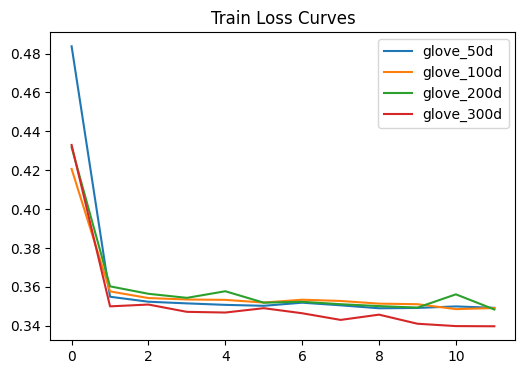

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Train Loss Curves')

for i in range(len(loss_curves)):
    plt.plot(loss_curves[i][0], label=list(embeddings_dict.keys())[i])

plt.legend()
plt.show()

In [ ]:
# TODO move below to another place

In [ ]:
# getting data to the correct format
X_train_tensor = torch.tensor(embeddings_dict['glove_50d']['X_train'], dtype=torch.float32)
y_train_tensor = torch.tensor(embeddings_dict['glove_50d']['y_train'], dtype=torch.long)
X_val_tensor = torch.tensor(embeddings_dict['glove_50d']['X_val'], dtype=torch.float32)
y_val_tensor = torch.tensor(embeddings_dict['glove_50d']['y_val'], dtype=torch.long)

# making dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# making data loader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train_tensor.shape[1]
hidden_size = 60
num_classes = 2
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def compute_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    macro_precision = precision_score(labels, preds, average='macro')
    macro_recall = recall_score(labels, preds, average='macro')
    return accuracy, macro_f1, macro_precision, macro_recall

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    all_preds = []
    all_labels = []
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        all_preds.extend(pred.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss /= len(dataloader)
    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return train_loss, accuracy, macro_f1, macro_precision, macro_recall

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size

    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return test_loss, accuracy, macro_f1, macro_precision, macro_recall


def log_metrics(epoch, train_metrics, test_metrics):
    print(f"Epoch {epoch}:")
    print(f"Training Metrics - Loss: {train_metrics[0]:.4f}, Accuracy: {train_metrics[1]*100:.2f}%, Macro F1: {train_metrics[2]:.4f}, Macro Precision: {train_metrics[3]:.4f}, Macro Recall: {train_metrics[4]:.4f}")
    print(f"Test Metrics - Loss: {test_metrics[0]:.4f}, Accuracy: {test_metrics[1]*100:.2f}%, Macro F1: {test_metrics[2]:.4f}, Macro Precision: {test_metrics[3]:.4f}, Macro Recall: {test_metrics[4]:.4f}")

In [ ]:
epochs = 100
train_losses, test_losses = [], []
train_f1, test_f1 = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_accuracy, test_accuracy = [], []
for t in range(epochs):
    train_metrics = train(train_dataloader, model, loss_fn, optimizer)
    test_metrics = test(val_dataloader, model, loss_fn)

    if t % 10 == 0:
        print('\n---------------------------------------')
        log_metrics(t, train_metrics, test_metrics)

    train_losses.append(train_metrics[0])
    test_losses.append(test_metrics[0])
    train_accuracy.append(train_metrics[1])
    test_accuracy.append(test_metrics[1])
    train_f1.append(train_metrics[2])
    test_f1.append(test_metrics[2])
    train_precision.append(train_metrics[3])
    test_precision.append(test_metrics[3])
    train_recall.append(train_metrics[4])
    test_recall.append(test_metrics[4])

print("Done!")


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.6787, Accuracy: 67.83%, Macro F1: 0.4147, Macro Precision: 0.3896, Macro Recall: 0.4708
Test Metrics - Loss: 0.6612, Accuracy: 72.64%, Macro F1: 0.4208, Macro Precision: 0.3632, Macro Recall: 0.5000

---------------------------------------
Epoch 10:
Training Metrics - Loss: 0.4528, Accuracy: 86.83%, Macro F1: 0.8427, Macro Precision: 0.8294, Macro Recall: 0.8626
Test Metrics - Loss: 0.4519, Accuracy: 86.08%, Macro F1: 0.8300, Macro Precision: 0.8217, Macro Recall: 0.8404

---------------------------------------
Epoch 20:
Training Metrics - Loss: 0.3691, Accuracy: 86.83%, Macro F1: 0.8427, Macro Precision: 0.8294, Macro Recall: 0.8626
Test Metrics - Loss: 0.3805, Accuracy: 86.08%, Macro F1: 0.8300, Macro Precision: 0.8217, Macro Recall: 0.8404

---------------------------------------
Epoch 30:
Training Metrics - Loss: 0.3554, Accuracy: 86.83%, Macro F1: 0.8427, Macro Precision: 0.8294, Macro Recall: 0.8626
Test

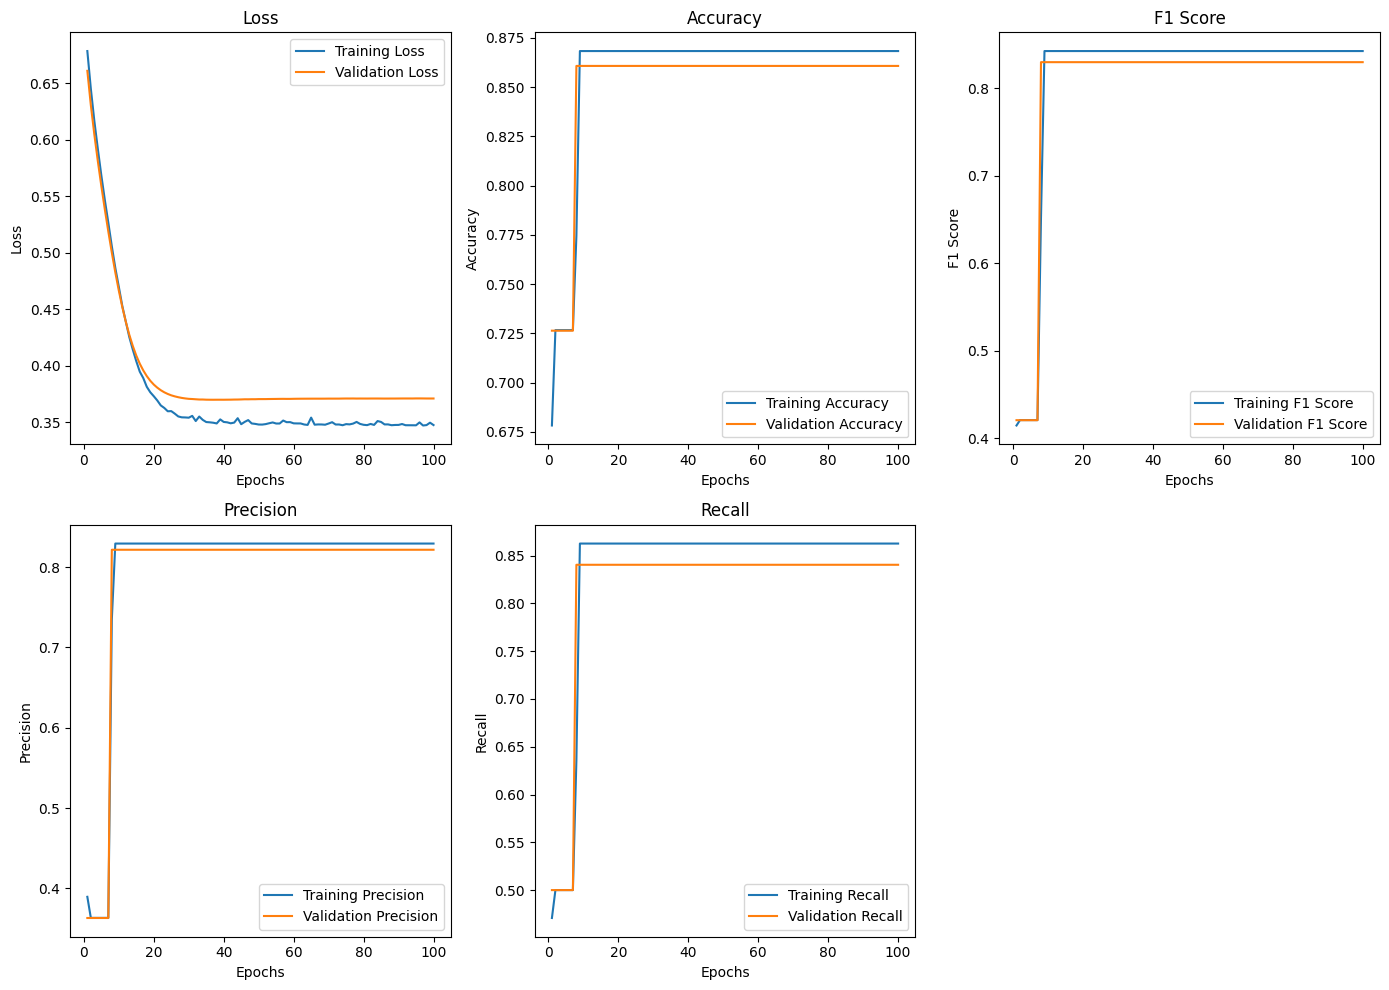

In [ ]:
def plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy,
                 train_f1, test_f1, train_precision, test_precision, train_recall, test_recall):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, test_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, train_f1, label='Training F1 Score')
    plt.plot(epochs_range, test_f1, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, train_precision, label='Training Precision')
    plt.plot(epochs_range, test_precision, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, train_recall, label='Training Recall')
    plt.plot(epochs_range, test_recall, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy, train_f1, test_f1,
             train_precision, test_precision, train_recall, test_recall)

In [ ]:
# TODO debug this!

#### **Additional #1 - XLM - RoBERTa (Fine Tuning)**

In [8]:
def build_joint_dataset(datasets: list[tuple], split_names=None):
    if split_names is None:
        split_names = ['train', 'validation', 'test'][:len(datasets)]
    joint_dataset = {name: Dataset.from_dict({'text': ds[0], 'label': ds[1]})
                     for name, ds in zip(split_names, datasets)}
    joint_dataset = DatasetDict(joint_dataset)
    return joint_dataset


def untangle_dataset(datasetdict):
    X_train = np.array(datasetdict["train"]["hidden_state"])
    X_val = np.array(datasetdict["validation"]["hidden_state"])
    X_test = np.array(datasetdict["test"]["hidden_state"])
    y_train = np.array(datasetdict["train"]["label"])
    y_val = np.array(datasetdict["validation"]["label"])
    y_test = np.array(datasetdict["test"]["label"])
    return X_train, X_val, X_test, y_train, y_val, y_test


In [9]:
# example

# 1. import pre processed data
train_df, test_df = load_preprocessed_data(columns=['ner_trans_clean_comments'],
                                           train_path=TRAIN_PREPROCESSED_PATH_DRIVE, test_path=TEST_PREPROCESSED_PATH_DRIVE)

# 2. group data by property
grouped_train_df = groupby_property(train_df)
grouped_test_df = groupby_property(test_df)

# 3. train-val-test split
X = np.array(grouped_train_df['ner_trans_clean_comments'])
y = np.array(grouped_train_df['unlisted'])
X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y)

get_prop = lambda d: round(len(d) / len(X) * 100, 2)
print('Dataset shapes:')
print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
print(f"\nTotal observations: {len(X)}")

# 4. create DatasetDict object
datasets = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

joint_dataset = build_joint_dataset(datasets)

Dataset shapes:
	Train: 4998 (79.99%)
	Val: 625 (10.0%)
	Test: 625 (10.0%)

Total observations: 6248


In [10]:
# 5. tokenize
# 5.1. get tokenizer
model_ckpt = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# 5.2. apply to whole dataset
def tokenize(batch):
 return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

dataset_encoded = joint_dataset.map(tokenize, batched=True, batch_size=None)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

In [11]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4998
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 625
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 625
    })
})

In [12]:
# 6. train model
# 6.1. instantiate model
num_labels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

# 6.2. create function for computing metrics to track during training and evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    recall = recall_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'macro_f1': f1, 'macro_recall': recall, 'macro_precision': precision}

# 6.3. fitting model
batch_size = 16
num_train_epochs = 3
logging_steps = len(dataset_encoded['train']) // batch_size
output_dir = './results'
logging_dir = './logs'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_dir=logging_dir,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded['train'],
                  eval_dataset=dataset_encoded['validation'],
                  tokenizer=tokenizer)

trainer.train()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Recall,Macro Precision
1,0.386500,0.380544,0.860800,0.830009,0.840392,0.821656
2,0.359100,0.389133,0.860800,0.830009,0.840392,0.821656
3,0.353100,0.389868,0.860800,0.830009,0.840392,0.821656


TrainOutput(global_step=939, training_loss=0.36656973638727514, metrics={'train_runtime': 435.6592, 'train_samples_per_second': 34.417, 'train_steps_per_second': 2.155, 'total_flos': 986271791016960.0, 'train_loss': 0.36656973638727514, 'epoch': 3.0})

In [ ]:
# 7. make predictions on the test set
preds_output = trainer.predict(dataset_encoded['test'])
print(preds_output.metrics)

{'test_loss': 0.2444491684436798,
 'test_accuracy': 0.9364705882352942,
 'test_macro_f1': 0.4835965978128797,
 'test_macro_recall': 0.5,
 'test_macro_precision': 0.4682352941176471,
 'test_runtime': 3.0386,
 'test_samples_per_second': 139.867,
 'test_steps_per_second': 8.886}

In [16]:
# TODO if not able to fix issue use a torch implementation, e.g.:

MODEL_CKPT = 'xlm-roberta-base'
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=2)

# import pre processed data
train_df, test_df = load_preprocessed_data(columns=['ner_trans_clean_comments'],
                                           train_path=TRAIN_PREPROCESSED_PATH_DRIVE, test_path=TEST_PREPROCESSED_PATH_DRIVE)

# group data by property
grouped_train_df = groupby_property(train_df)
grouped_test_df = groupby_property(test_df)

# train-val-test split
X = np.array(grouped_train_df['ner_trans_clean_comments'])
y = np.array(grouped_train_df['unlisted'])
X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LEN)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def compute_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    macro_precision = precision_score(labels, preds, average='macro')
    macro_recall = recall_score(labels, preds, average='macro')
    return accuracy, macro_f1, macro_precision, macro_recall

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    all_preds = []
    all_labels = []
    train_loss = 0
    for batch in dataloader:
        ids, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']
        ids, mask, y = ids.to(device), mask.to(device), y.to(device)

        # Compute prediction error
        pred = model(input_ids=ids, attention_mask=mask)[0]
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        all_preds.extend(pred.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss /= len(dataloader)
    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return train_loss, accuracy, macro_f1, macro_precision, macro_recall

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            ids, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)

            # Compute prediction error
            pred = model(input_ids=ids, attention_mask=mask)[0]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size

    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return test_loss, accuracy, macro_f1, macro_precision, macro_recall


def log_metrics(epoch, train_metrics, test_metrics):
    print(f"Epoch {epoch}:")
    print(f"Training Metrics - Loss: {train_metrics[0]:.4f}, Accuracy: {train_metrics[1]:.2f}%, Macro F1: {train_metrics[2]:.4f}, Macro Precision: {train_metrics[3]:.4f}, Macro Recall: {train_metrics[4]:.4f}")
    print(f"Test Metrics - Loss: {test_metrics[0]:.4f}, Accuracy: {test_metrics[1]:.2f}%, Macro F1: {test_metrics[2]:.4f}, Macro Precision: {test_metrics[3]:.4f}, Macro Recall: {test_metrics[4]:.4f}")


train_losses, test_losses = [], []
train_f1, test_f1 = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_accuracy, test_accuracy = [], []
for t in range(EPOCHS):
    train_metrics = train(train_dataloader, model, loss_fn, optimizer)
    test_metrics = test(val_dataloader, model, loss_fn)

    if t % 1 == 0:
        print('\n---------------------------------------')
        log_metrics(t, train_metrics, test_metrics)

    train_losses.append(train_metrics[0])
    test_losses.append(test_metrics[0])
    train_accuracy.append(train_metrics[1])
    test_accuracy.append(test_metrics[1])
    train_f1.append(train_metrics[2])
    test_f1.append(test_metrics[2])
    train_precision.append(train_metrics[3])
    test_precision.append(test_metrics[3])
    train_recall.append(train_metrics[4])
    test_recall.append(test_metrics[4])

print("Done!")


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.3516, Accuracy: 86.61%, Macro F1: 0.8402, Macro Precision: 0.8269, Macro Recall: 0.8602
Test Metrics - Loss: 0.4105, Accuracy: 86.08%, Macro F1: 0.8300, Macro Precision: 0.8217, Macro Recall: 0.8404

---------------------------------------
Epoch 1:
Training Metrics - Loss: 0.3505, Accuracy: 86.67%, Macro F1: 0.8412, Macro Precision: 0.8275, Macro Recall: 0.8620
Test Metrics - Loss: 0.4038, Accuracy: 86.08%, Macro F1: 0.8300, Macro Precision: 0.8217, Macro Recall: 0.8404

---------------------------------------
Epoch 2:
Training Metrics - Loss: 0.3534, Accuracy: 86.71%, Macro F1: 0.8415, Macro Precision: 0.8280, Macro Recall: 0.8618
Test Metrics - Loss: 0.3953, Accuracy: 86.08%, Macro F1: 0.8300, Macro Precision: 0.8217, Macro Recall: 0.8404
Done!


In [ ]:
def plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy,
                 train_f1, test_f1, train_precision, test_precision, train_recall, test_recall):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, test_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, train_f1, label='Training F1 Score')
    plt.plot(epochs_range, test_f1, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, train_precision, label='Training Precision')
    plt.plot(epochs_range, test_precision, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, train_recall, label='Training Recall')
    plt.plot(epochs_range, test_recall, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy, train_f1, test_f1,
             train_precision, test_precision, train_recall, test_recall)

#### **Additional #2**

In [ ]:
# eg:
# ... model_ckpt = 'google/mt5-base'

## **Model Comparison**

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
# bonus metric: ROC-AUC

## **Plug-and-Play Solution**

In [ ]:
# RECALL THAT WHEN PRE PROCESSING THE DATA THE PROPERTIES WITH NO REVIEWS WERE DROPPED
# THEREFORE, NOT ALL PROPERTIES WE NEED TO MAKE PREDICTIONS ON ARE IN THE TEST SET
# WE FIRST NEED TO GET THEM (TEST_INFO_RAW FOR EXAMPLE)